# Project 2 

Henry Vasquez, Sergio Ortega

1. Identify a large 2-node network dataset—you can start with a dataset in a repository. Your data should meet the criteria that it consists of ties between and not within two (or more) distinct groups.

2. Reduce the size of the network using a method such as the island method described in chapter 4 of social network analysis.

3. What can you infer about each of the distinct groups?

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
from networkx import algorithms
from networkx.algorithms import bipartite as bi

%matplotlib inline

# Languages Dataset

The dataset used in this project is a unicode language dataset. It includes the country code, the language code and the percentage of usage for that language. For example, 61% of people in the country code SD (Sudan) speak the language code ar (Arabic). For this project we will be looking to identify the different languages spoken in countries and using the island method to find the most popular languages in the world based on their dominance across different countries.

In [2]:
data = pd.read_csv('https://raw.githubusercontent.com/hvasquez81/Data620/master/Project%202/languages.csv')
data['weight'] = data['weight']*100
data.head()

country language  weight
0      IO       en   100.0
1      SY       hy     1.8
2      RO       el     0.0
3      CM      ewo     3.1
4      SD       ar    61.0

In [3]:
#split node types up
country = list(data['country'].unique())
language = list(data['language'].unique())

In [4]:
#create graph
B = nx.Graph()

In [5]:
#add nodes
B.add_nodes_from(country, bipartite=0) #bottom nodes
B.add_nodes_from(language, bipartite=1) #top nodes

In [6]:
#add edges
B.add_weighted_edges_from([(row['country'], row['language'], row['weight']) for ind, row in data.iterrows()], weight='weight')

In [7]:
#connected?
nx.is_connected(B)

False

C:\Users\henri\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


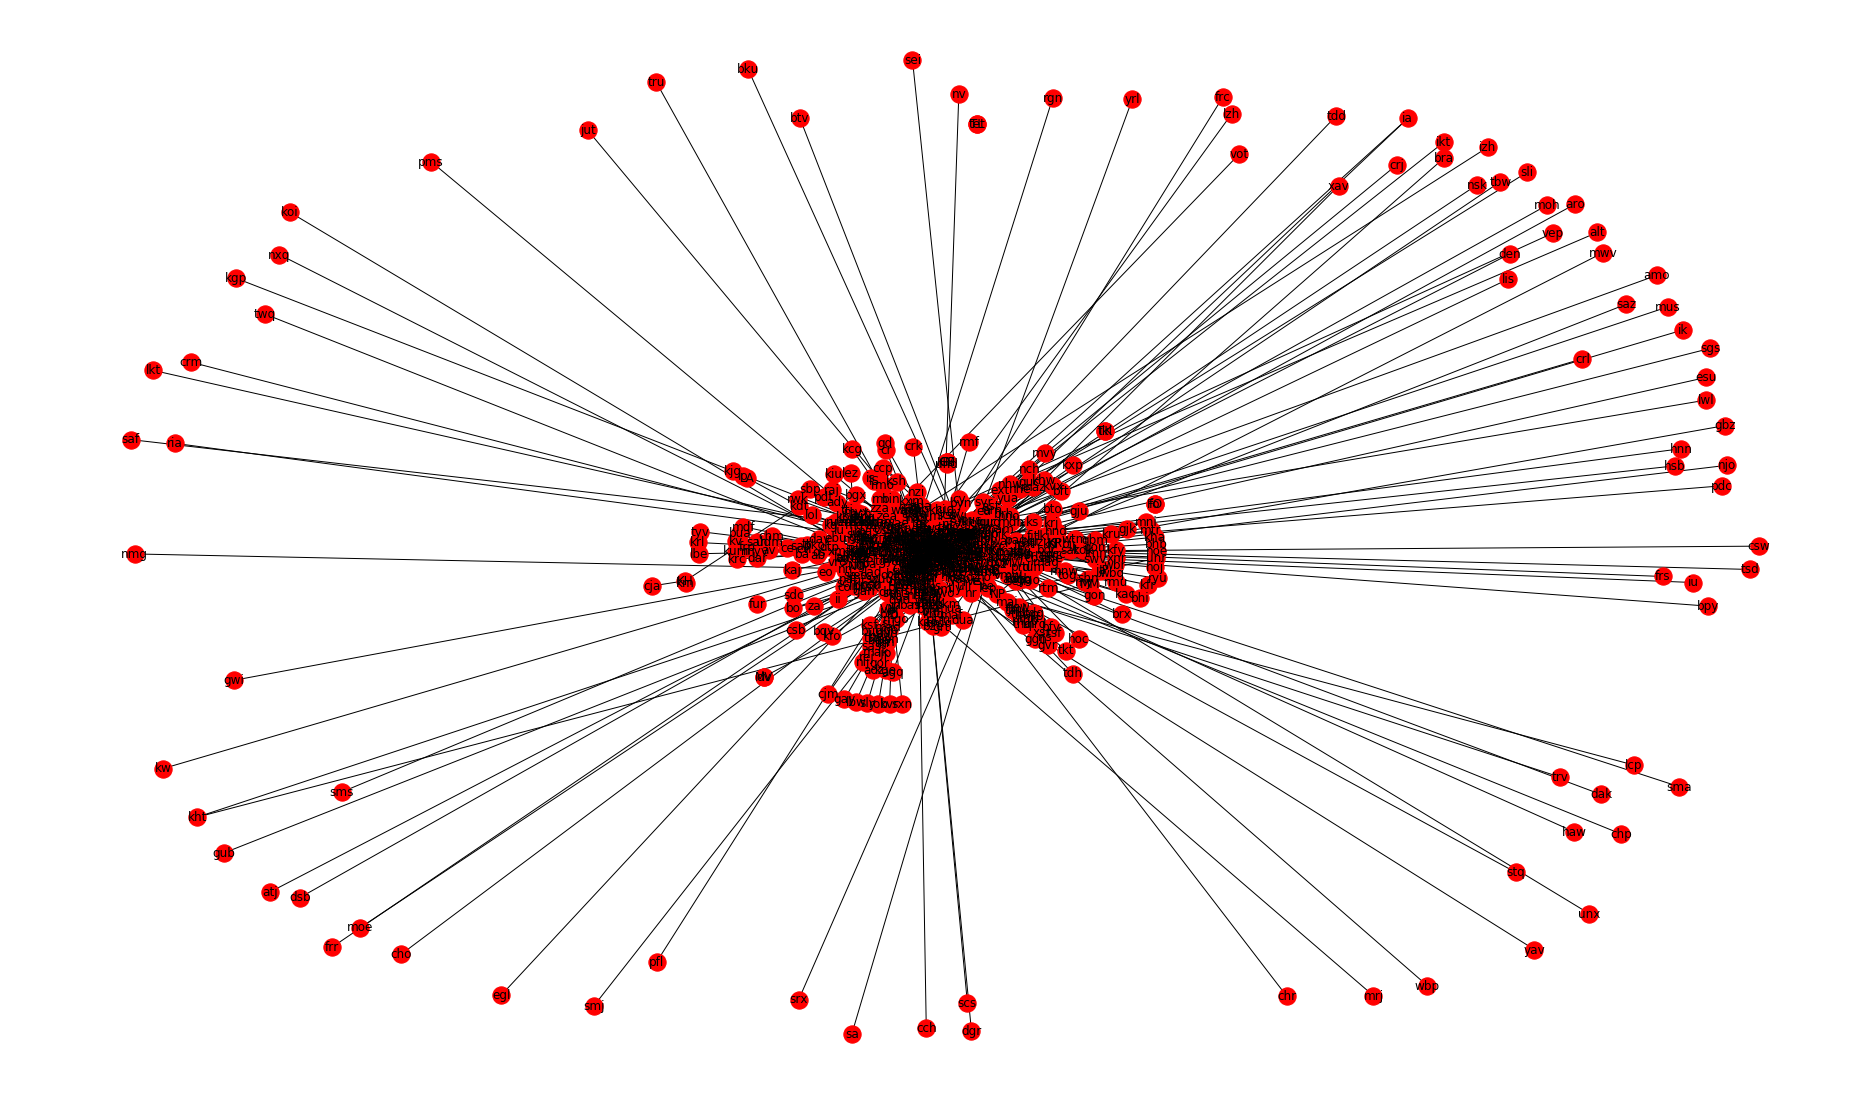

In [8]:
plt.rcParams["figure.figsize"] = (25,15)
nx.draw(B, nx.spring_layout(B), with_labels=True)

In [9]:
#stats
print(nx.info(B))

Name: 
Type: Graph
Number of nodes: 867
Number of edges: 1255
Average degree:   2.8950


# Redrawing

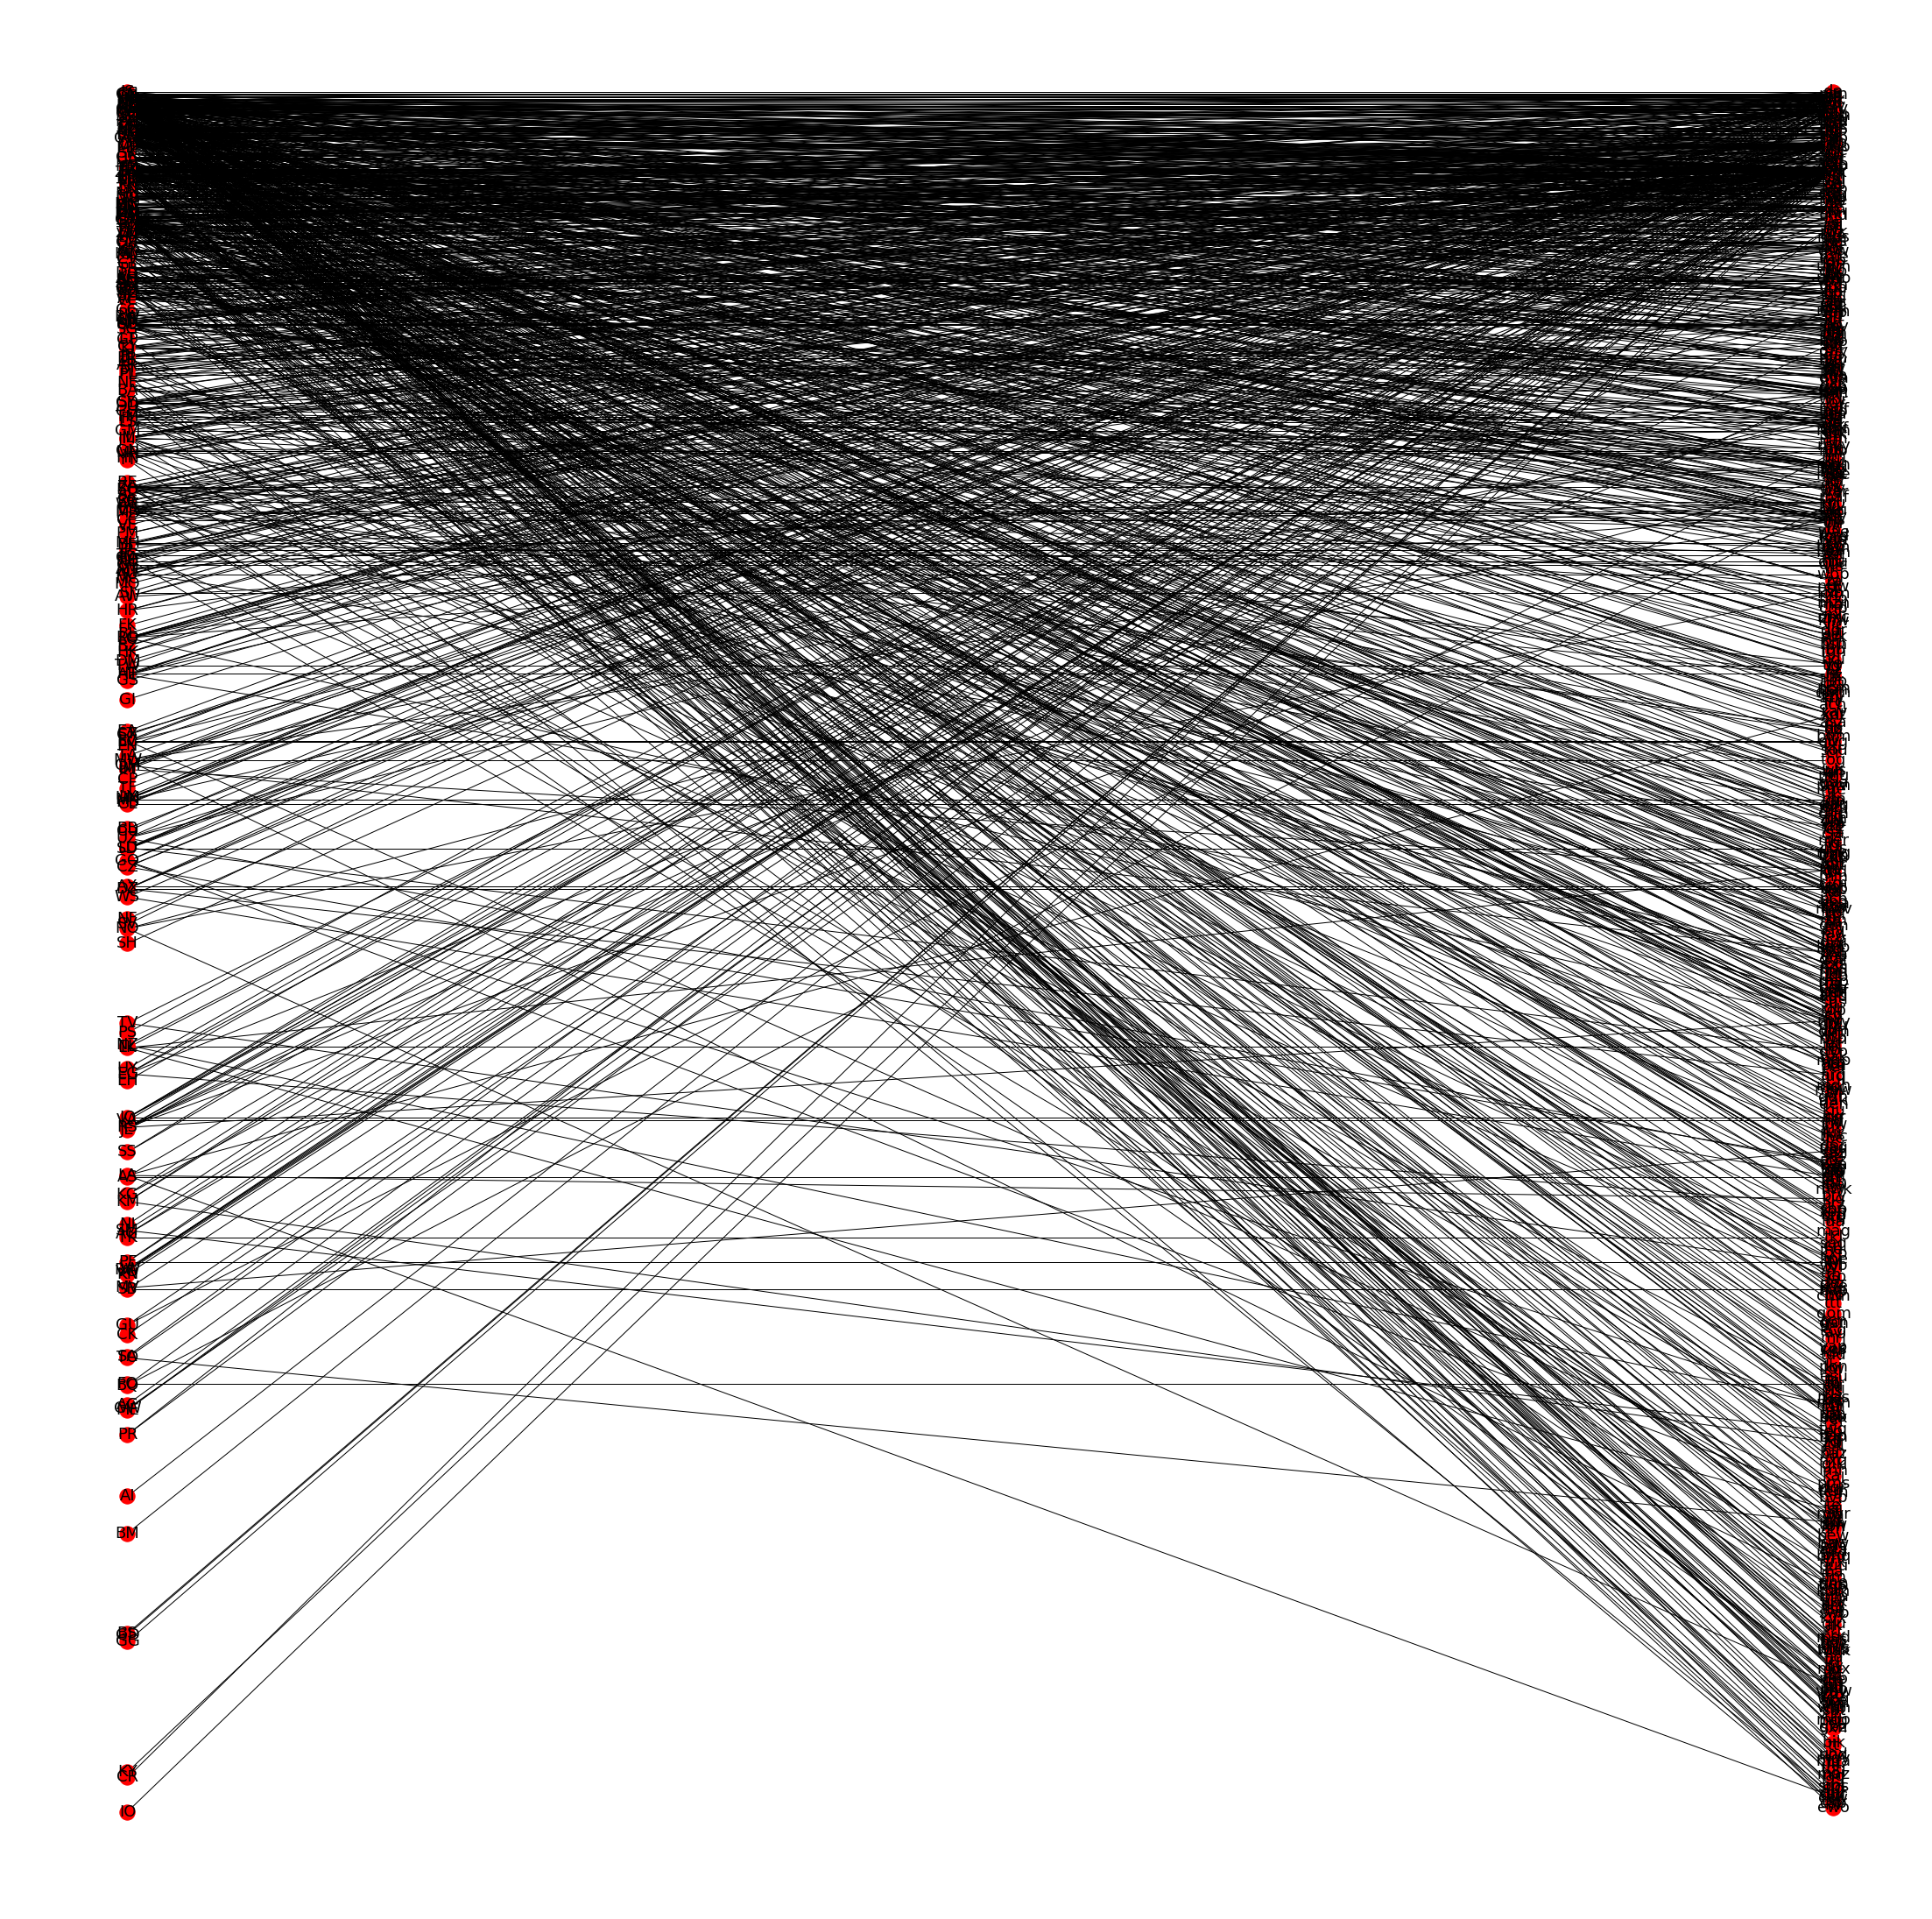

In [10]:
pos = {node:[0, i] for i,node in enumerate(data['country'])}
pos.update({node:[1, i] for i,node in enumerate(data['language'])})
plt.rcParams["figure.figsize"] = (30,30)
nx.draw(B, pos, with_labels=False)
for p in pos:  
    pos[p][1] += 0.25
nx.draw_networkx_labels(B, pos, font_size=18)
plt.show()

The chart above is just reorganized to look more like a bipartite graph. On the left side are the countries and the right are the languages that make up each contry. The code used to restructure the graph was found on a stack overflow post here: https://stackoverflow.com/questions/30850688/construct-bipartite-graph-from-columns-of-python-dataframe

# The Island Method

The trim_edges and island_method fuctions were taken from the Social Network Analysis textbook. There was a slight modification, and the number of iterations used was 5.

In [11]:
def trim_edges(g, weight=1):
        g2=nx.Graph()
        for f, to, edata in g.edges(data=True):
                if edata['weight'] >= weight:
                        g2.add_edge(f,to,weight=edata)
        return g2

In [12]:
def island_method(g, iterations=5):
    weights= [edata['weight'] for f,to,edata in g.edges(data=True)]

    mn=int(min(weights))
    mx=int(max(weights))
    #compute the size of the step, so we get a reasonable step in iterations
    step=int((mx-mn)/iterations)

    return [[threshold, trim_edges(g, threshold)] for threshold in range(mn,mx,step)]

In [13]:
islands=island_method(B, 5)
for i in islands:
    # print the threshold level, size of the graph, and number of connected components
    print("% Threshold : ",i[0], "\t Nodes: ", nx.number_of_nodes(i[1]), "\t Edges: ", nx.number_of_edges(i[1]), "\t Number of Connected Components: ", len(list(nx.connected_component_subgraphs(i[1]))))

% Threshold :  0 	 Nodes:  867 	 Edges:  1255 	 Number of Connected Components:  5
% Threshold :  20 	 Nodes:  411 	 Edges:  400 	 Number of Connected Components:  38
% Threshold :  40 	 Nodes:  368 	 Edges:  317 	 Number of Connected Components:  61
% Threshold :  60 	 Nodes:  334 	 Edges:  270 	 Number of Connected Components:  67
% Threshold :  80 	 Nodes:  251 	 Edges:  189 	 Number of Connected Components:  62


# Inferences

At the 0% threshold, which includes all edges that are greater than 0 in weight, there are 867 nodes within 5 islands. This doesn't help much since it includes all of the data and doesn't reduce the network. At the 20% threshold, we're down to 411 nodes within 38 islands. This is the point at which we have the most diverse countries in regards to languages spoken with the threshold levels chosen. At this water level, the countries will have at most a connection to 5 different languages. At the 40% threshold, there are 368 nodes among 61 islands. At this waterlevel countries are primarily dominated by a maximum of 2 languages. The 60% threshold has 334 nodes within 67 islands. The countries at this level have 1 popular language, although other languages that are not so popular may exist. At the final threshold of 80%, this leaves 251 nodes among 62 islands. The countries at this waterlevel have 1 dominant language and possibly other very less frequently used languages that make up less than 20% of the language spoken.

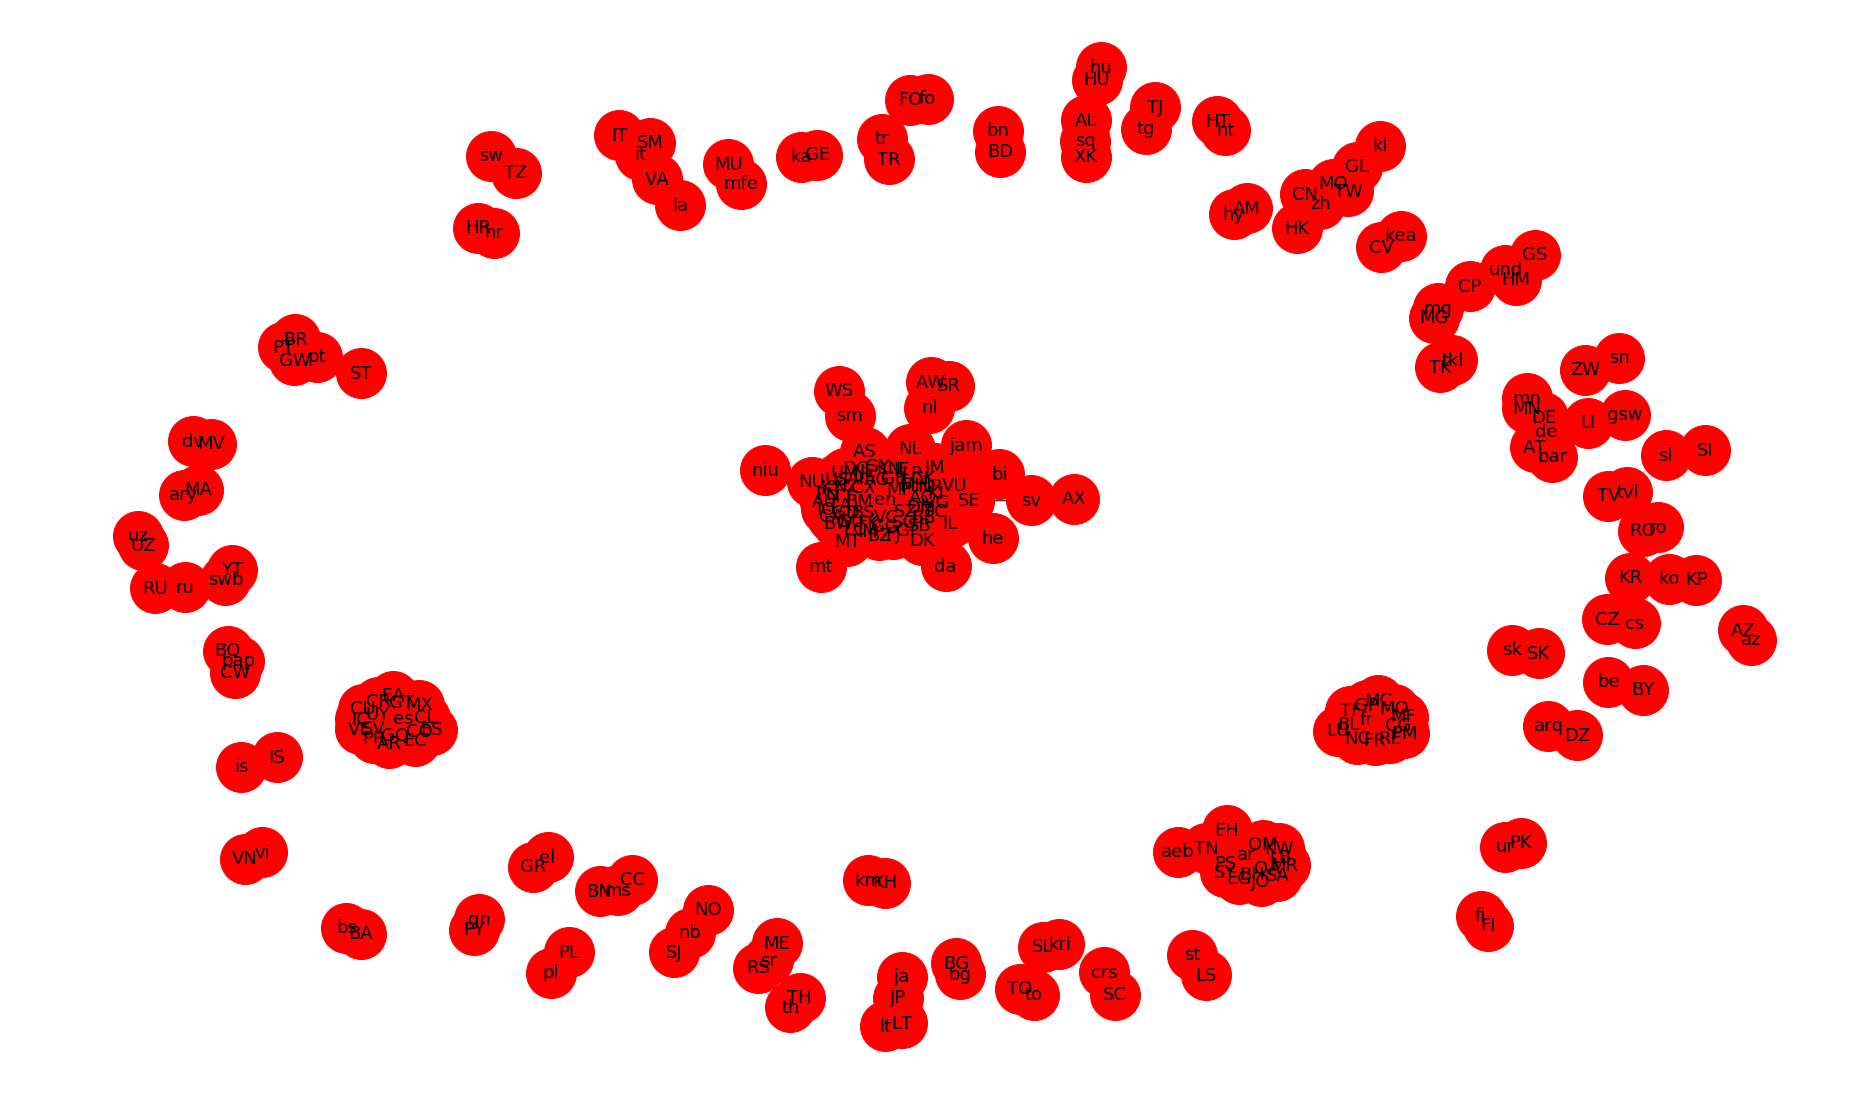

In [14]:
#80% threshold
B_80 = islands[4][1]

#create graph
G = nx.Graph()

#add nodes and edges
G.add_nodes_from(B_80.nodes())
G.add_edges_from(B_80.edges())

plt.rcParams["figure.figsize"] = (25,15)
nx.draw(G, with_labels=True, node_size=2500, font_size=18)

Looking at the graph, we see that a majority of the islands are 1-1 or have a relatively low number of connections. These are countries where the languages spoken are most likely unique and therefore only dominate in these countries. It's possible that these languages exist outside of this graph, but the popularity of the language is very small.

There's about 2 subgraphs with significant size in this graph. We can take a closer look by using the connect_components_subgraphs function and graphing.

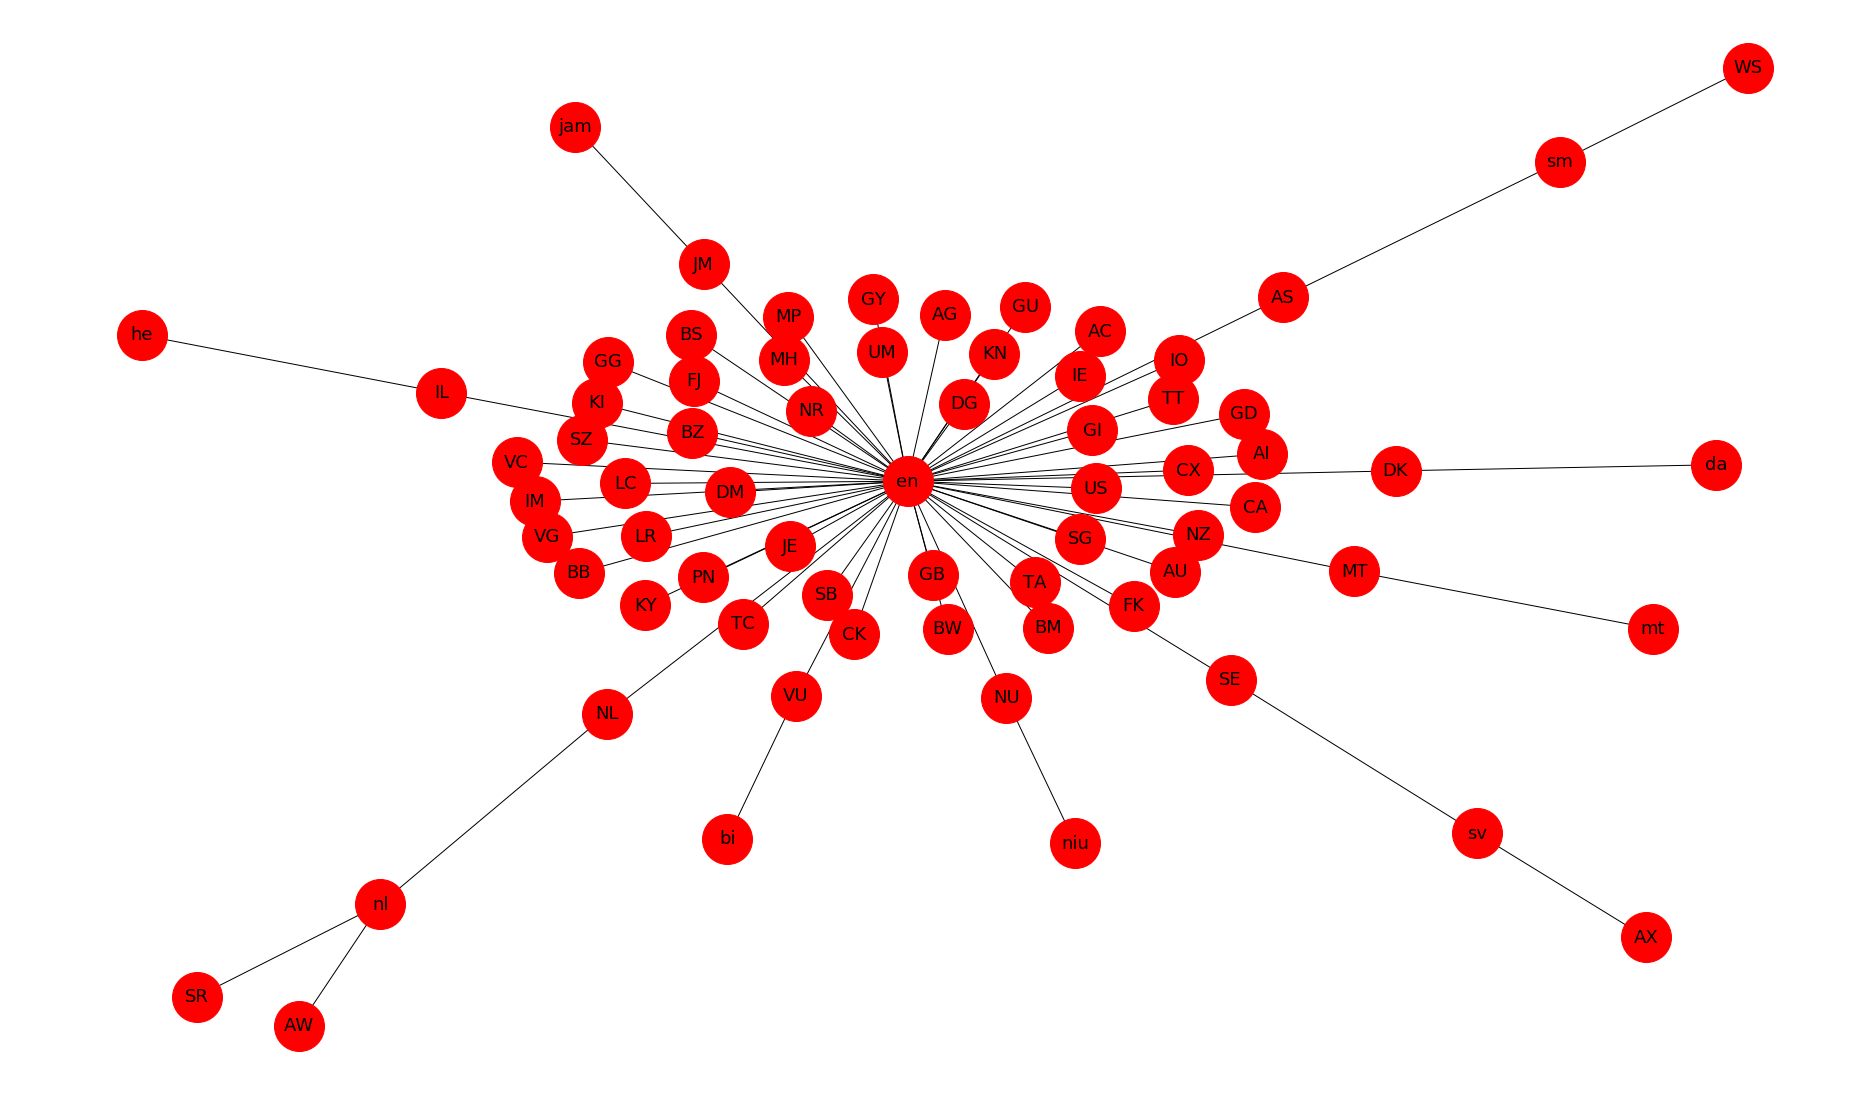

In [15]:
#get subgraphs
sub_graphs = list(nx.connected_component_subgraphs(B_80))

#create graph
sub1 = nx.Graph()

#add nodes and edges
sub1.add_nodes_from(sub_graphs[0].nodes())
sub1.add_edges_from(sub_graphs[0].edges())

plt.rcParams["figure.figsize"] = (25,15)
nx.draw(sub1, with_labels=True, node_size=2500, font_size=18)

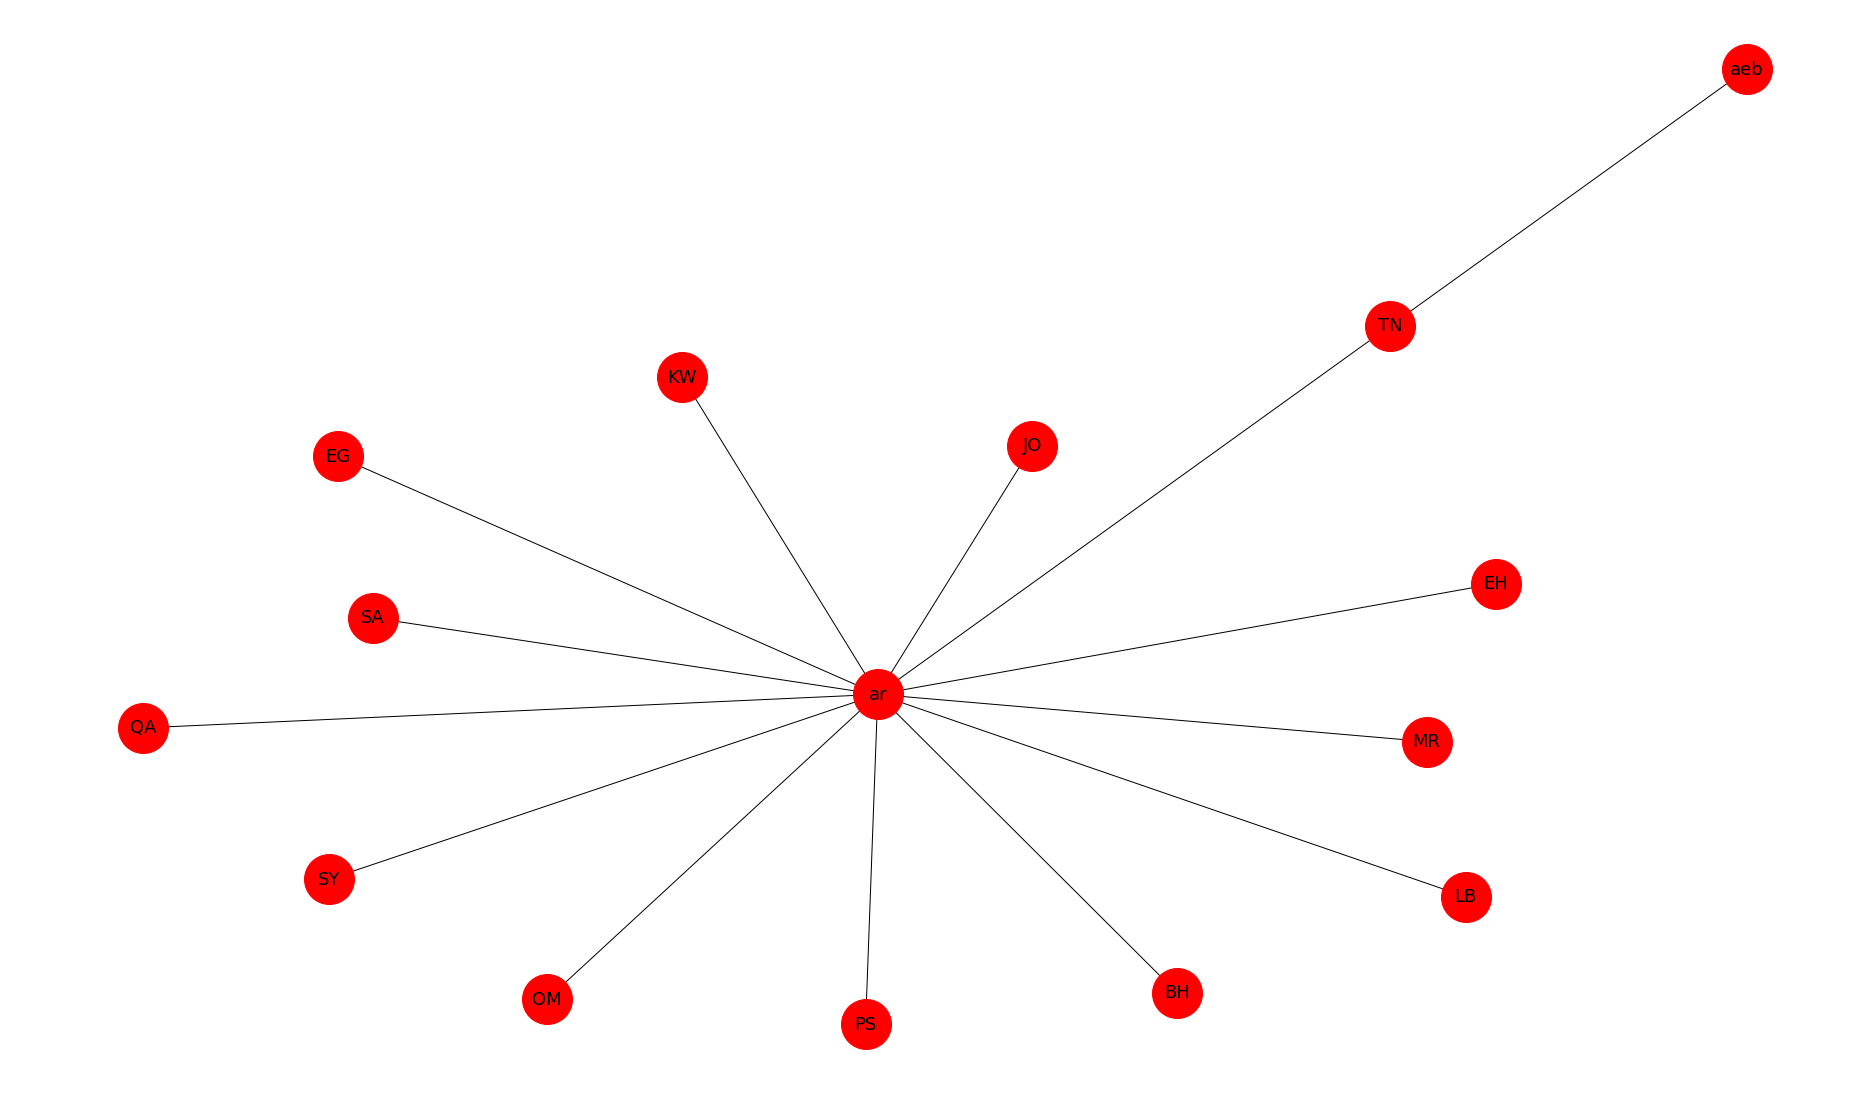

In [16]:
#create graph
sub2 = nx.Graph()

#add nodes and edges
sub2.add_nodes_from(sub_graphs[1].nodes())
sub2.add_edges_from(sub_graphs[1].edges())

plt.rcParams["figure.figsize"] = (25,15)
nx.draw(sub2, with_labels=True, node_size=2500, font_size=18)

According to the 2 subgraphs, the countries in the first graph are dominated by English having at least 80% of the population speaking English. In the second graph, Arabic is the dominant language spoken among the 1 countries. The countries in this graph are all middle east countries from my understanding.

# Conclusion

English and Arabic are the 2 languages that seem to be dominant among multiple countries. Dominant in this case is defined as having an 80% of more usage rate. Other languages that are dominant seem to be within only a few countries or less. In most cases, countries that are dominated by 1 language are where the language is soley spoken, meaning the language isn't very popular else where. Arabic, although being a popular language and one of the most spoken languages in the world, is confined to the middle east, whereas English is more spread across the globe.